# Restaurant Visitor Forecasting

## Table of contents

* 1. Introduction
* 2. Preparations
    * 2.1. Load libraries
    * 2.1. Load data
* 3. Overview
    * 3.1. air_visit_data
    * 3.2. Air Reserve
    * 3.3. Hpg reserve
    * 3.4. Air Reserve
    * 3.5. Air store
    * 3.6. Hpg store
    * 3.7. date_info
    * 3.8. Store IDs
    * 3.9. Submission data
* 4. Individual feature visualisation
    * 3.1. Air Visits
    * 4.2 Hpg reserve
    * 4.3 Hpg store
    * 4.4 air_reserve
    * 4.5. Holiday
* 5. Modeling
* 6. Ref

## 1. Introduction
이 대회에서는 예약 및 방문 데이터를 사용하여 **미래 날짜의 레스토랑 총 방문자 수를 예측**해야 합니다.

**평가**
* **RMSLE**를 사용합니다
\\[ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( p_i + 1) - \log(a_i + 1))^2} }\\]

* \\(n\\) is 관측된 총 숫자   
* \\(p_i\\) is 예상한 방문자 수   
* \\(a_i\\) is 실제 방문자 수   
* \\(\log𝑥\\) is \\(x\\)의 자연로그


**제공되는 데이터**
* Hot Pepper Gourmet (hpg): 사용자들이 레스토랑을 검색하고 온라인 예약할 수 있는 서비스
* AirREGI / Restaurant Board (air): 매장에서 사용하는 예약관리시스템 (POS)
* 훈련 데이터는 2016년~2017년 4월까지, 테스트 데이터는 2017년 4월과 5월 마지막주까지 제공됩니다
* 테스트 데이터에는 골든위크 기간이 포함되어있습니다.
* 테스트 데이터 세트에는 레스토랑이 문을 닫고 방문자가 없는 날이 있었습니다. 스코어링 시 무시됩니다. 훈련 세트는 레스토랑이 문을 닫는 날을 생략합니다.

**파일 설명**
* air_visit_data.csv: air 레스토랑의 과거 방문 데이터입니다. 이것은 본질적으로 주요 훈련 데이터 세트입니다.  
* air_reserve.csv / hpg_reserve.csv: air / hpg 시스템을 통한 예약.  
* air_store_info.csv / hpg_store_info.csv: 장르 및 위치를 포함한 air / hpg 레스토랑에 대한 세부 정보입니다.  
* store_id_relation.csv: air와 hpg id를 연결합니다.
* date_info.csv: 일본 공휴일에 플래그를 지정합니다.  
* sample_submission.csv: 테스트 세트 역할을 합니다. id는 air id와 방문 날짜를 결합하여 구성됩니다.

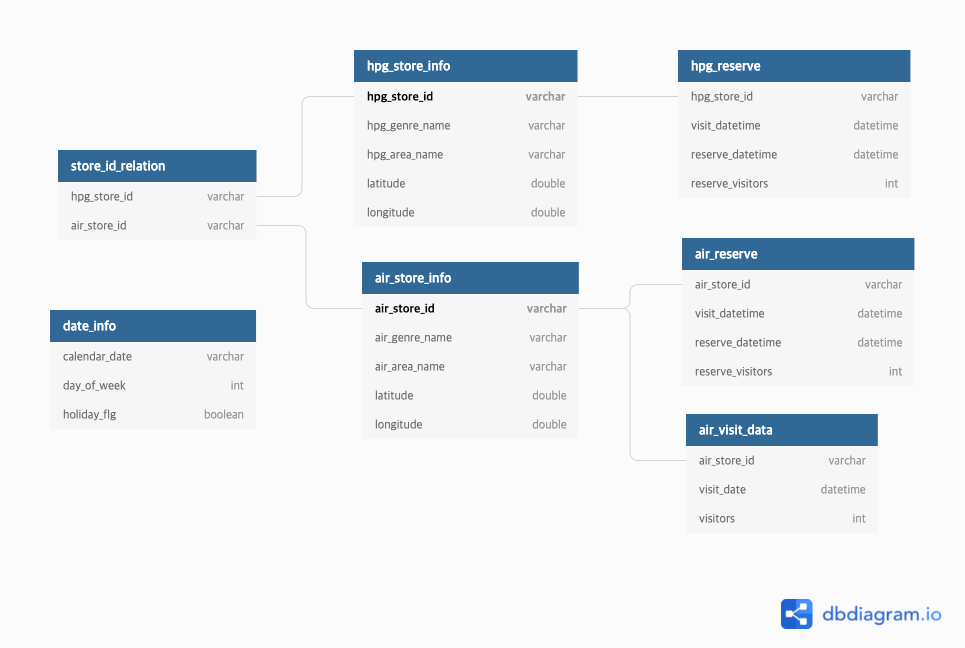

## 2. Preparations

### 2.1 Load libraries

In [8]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import math, warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

# mpl_toolkits.basemap을 import 할 때 발생하는 KeyError:'PROJ_LIB' 에러를 해결하기 위해 PROJ_LIB 설정
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

from mpl_toolkits.basemap import Basemap

### 2.2 Load data

In [11]:
data_path = './data/'

air_visits = pd.read_csv(data_path + 'air_visit_data.csv')
air_reserve = pd.read_csv(data_path + 'air_reserve.csv')
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv')
air_store = pd.read_csv(data_path + 'air_store_info.csv')
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv')
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv')
date_info = pd.read_csv(data_path + 'date_info.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 3. Overview

### 3.1 air_visit_data

### air_visit_data
air 시스템에서 집계한 레스토랑의 과거 방문 데이터입니다
* air_store_id : air 시스템상의 상점 고유값
* visit_date : 방문일
* visitors : 방문자 수

In [12]:
air_visits.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


### 3.2 Air Reserve

air에서 이루어진 예약
- air_store_id - 항공 시스템에서 레스토랑의 id
- visit_datetime - 예약 시간(방문 시간)
- reserve_datetime - 예약한 시간
- reserve_visitors - 해당 예약의 방문자 수

In [13]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00,2016-01-01 16:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00,2016-01-01 19:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00,2016-01-01 19:00,6
3,air_877f79706adbfb06,2016-01-01 20:00,2016-01-01 16:00,2
4,air_db80363d35f10926,2016-01-01 20:00,2016-01-01 1:00,5


In [14]:
air_reserve.describe()

,reserve_visitors
count,92378.000000
mean,4.481749
std,4.919669
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


### 3.3 Hpg reserve

hpg 시스템에서 이루어진 예약
- hpg_store_id - hpg 시스템의 레스토랑 ID
- visit_datetime - 예약 시간
- reserve_datetime - 예약한 시간
- reserve_visitors - 해당 예약의 방문자 수

In [15]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [16]:
hpg_reserve.describe()

,reserve_visitors
count,2.000320e+06
mean,5.073785e+00
std,5.416172e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.000000e+02


### 3.4 Air store

일부 air 레스토랑에 대한 정보
- air_store_id
- air_genre_name
- air_area_name
- latitude
- longitude

In [17]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [18]:
air_store.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


### 3.5 Hpg store

일부 hpg 레스토랑에 대한 정보
- hpg_store_id
- hpg_genre_name
- hpg_area_name
- latitude
- longitude

In [19]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [20]:
hpg_store.describe()

,latitude,longitude
count,4690.000000,4690.000000
mean,35.810261,137.675816
std,2.138755,3.197233
min,33.311645,130.339313
25%,34.692109,135.498859
50%,35.659214,139.495733
75%,35.703381,139.737998
max,43.774846,143.714585


### 3.6 date_info

날짜/요일/공휴일 플레그를 포함한 데이터입니다
* calendar_date : 날짜 (yyyy-mm-dd)
* day_of_week : 요일
* holiday_flg : 공휴일 flag (공휴일이면 1, 아니면 0)

In [21]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### 3.7 Store IDs

- hpg_store_id
- air_store_id

In [22]:
store_id_map.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


### 3.8 Submission data

- id는 air_store_idand visit_date를 밑줄 로 연결하여 구성됩니다.
- visitors는 매장 및 날짜 조합에 대한 예상 방문자 수

In [23]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


### 3.9 Missing values

In [24]:
file_list = [air_visits, air_reserve ,hpg_reserve ,air_store ,hpg_store ,date_info ,store_id_map ,submission]

for file in file_list:
    for column in file.columns:
        print('{} : {}'.format(column, sum(file[column].isnull()))) # df.isnull() 사용해 결측치 파악
    print('***'*20)

air_store_id : 0
visit_date : 0
visitors : 0
************************************************************
air_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
************************************************************
hpg_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
************************************************************
air_store_id : 0
air_genre_name : 0
air_area_name : 0
latitude : 0
longitude : 0
************************************************************
hpg_store_id : 0
hpg_genre_name : 0
hpg_area_name : 0
latitude : 0
longitude : 0
************************************************************
calendar_date : 0
day_of_week : 0
holiday_flg : 0
************************************************************
air_store_id : 0
hpg_store_id : 0
************************************************************
id : 0
visitors : 0
************************************************************


결측치가 없는 데이터이다.

## 4. Individual feature visualisation

### 4.1 Air Visits

In [25]:
air_visits['visit_date'] = pd.to_datetime(air_visits['visit_date'])
air_visits['day'] = air_visits['visit_date'].dt.day
air_visits['dow'] = air_visits['visit_date'].dt.dayofweek
air_visits['year'] = air_visits['visit_date'].dt.year
air_visits['month'] = air_visits['visit_date'].dt.month
air_visits['week'] = air_visits['visit_date'].dt.week
air_visits['quarter'] = air_visits['visit_date'].dt.quarter
air_visits['visit_date'] = air_visits['visit_date'].dt.date
air_visits['year_mth'] = air_visits['year'].astype(str)+'-'+air_visits['month'].astype(str)

In [26]:
air_visits.columns

Index(['air_store_id', 'visit_date', 'visitors', 'day', 'dow', 'year', 'month',
       'week', 'quarter', 'year_mth'],
      dtype='object')

In [27]:
air_visits.head()

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,2016,1,3,1,2016-1


In [28]:
air_visits.dtypes

air_store_id    object
visit_date      object
visitors         int64
day              int64
dow              int64
year             int64
month            int64
week             int64
quarter          int64
year_mth        object
dtype: object

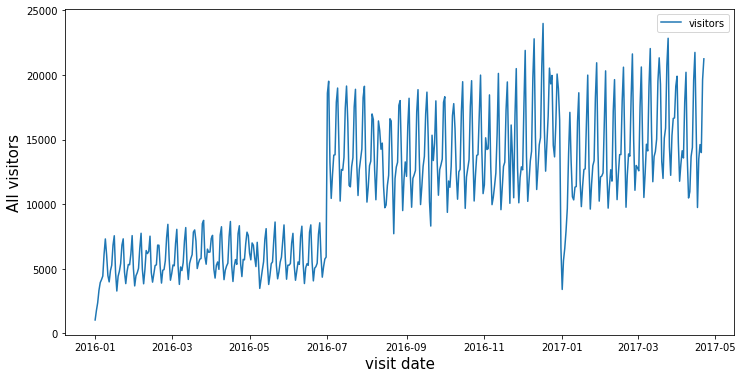

In [29]:
visitors_by_date = air_visits.groupby(['visit_date']).agg({'visitors': np.sum})
fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

- 2016년 7월에 총 방문객 수의 큰폭의 상승
- 2017년 1월에 큰 하락폭 존재
- 총 방문객 수의 패턴이 존재(일정 간격으로 패턴 반복)

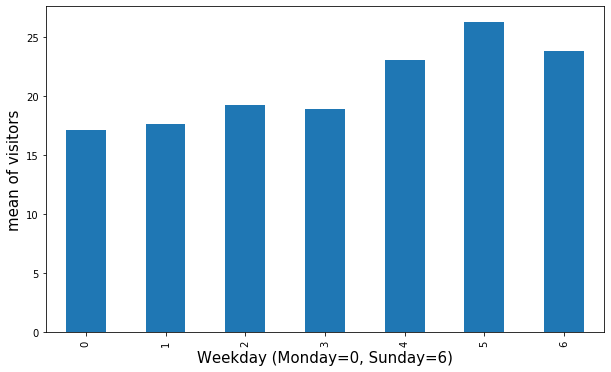

In [30]:
visitors_by_weekday = air_visits.groupby('dow')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Weekday (Monday=0, Sunday=6)',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

- 금,토, 일 평균 방문자 수가 다른 날들보다 많은 편

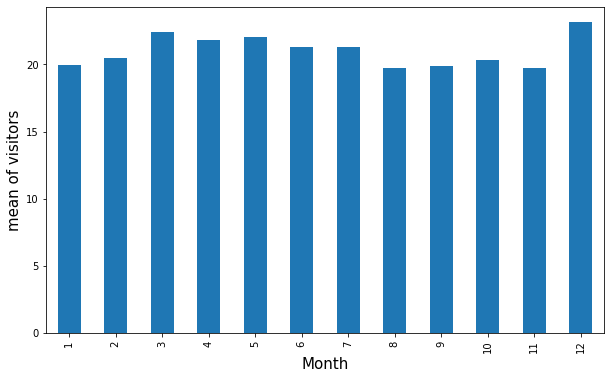

In [31]:
visitors_by_weekday = air_visits.groupby('month')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Month',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

* 목표 기간 방문자 수 추이  
예측할 목표 기간인 2017년 4월 마지막 주 ~ 5월까지의 예측을 위해 2016년 4월 15일 ~ 2016년 6월 15일의 데이터 추이 확인

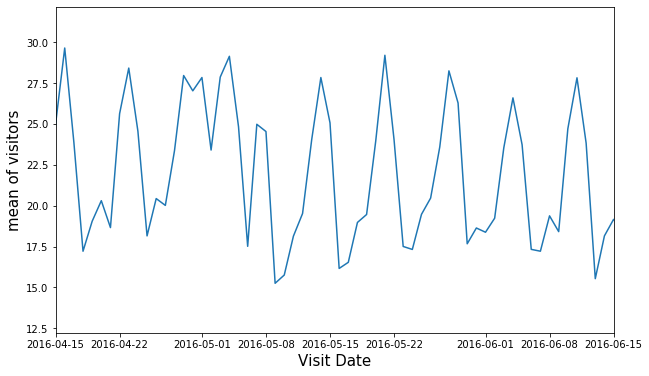

In [32]:
visitors_by_target = air_visits.groupby('visit_date')['visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_target.plot(kind='line', ax=ax)
plt.xlabel('Visit Date',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.xlim(['2016-4-15', '2016-6-15'])
plt.show()

* 월 기준 차트를 보면 12월이 가장 인기있는 달로 보이고, 3월~5월도 방문객수가 높은 편이다.

---

2017년 4월 마지막 주 ~ 5월까지의 예측을 위해 2016년 training data 보려는데 날짜가 6월 13일자 데이터만 뽑히는 중..8ㅅ8.

In [33]:
test_term_train = air_visits[air_visits["visit_date"].isin(pd.date_range('2016-04-15', '2017-06-15'))]
test_term_visitors = test_term_train.groupby('visit_date').agg({'visitors':np.sum})

In [34]:
air_visits[air_visits['visit_date'].isin(pd.date_range('2016-04-15', '2016-06-16'))]

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth
89,air_ba937bf13d40fb24,2016-04-28,26,28,3,2016,4,17,2,2016-4
479,air_25e9888d30b386df,2016-04-28,20,28,3,2016,4,17,2,2016-4
480,air_25e9888d30b386df,2016-04-29,21,29,4,2016,4,17,2,2016-4
1066,air_35512c42db0868da,2016-04-28,4,28,3,2016,4,17,2,2016-4
1067,air_35512c42db0868da,2016-04-29,21,29,4,2016,4,17,2,2016-4
...,...,...,...,...,...,...,...,...,...,...
250791,air_6c952e3c6e590945,2016-04-29,12,29,4,2016,4,17,2,2016-4
251206,air_0f2f96335f274801,2016-04-28,18,28,3,2016,4,17,2,2016-4
251207,air_0f2f96335f274801,2016-04-29,9,29,4,2016,4,17,2,2016-4
251559,air_c7d30ab0e07f31d5,2016-04-28,22,28,3,2016,4,17,2,2016-4


---

#### 식당 별 평균 방문자 수

In [35]:
air_visits.air_store_id.nunique()

829

In [36]:
air_visits.groupby('air_store_id').agg({'visitors':np.mean}).describe()

,visitors
count,829.000000
mean,21.203887
std,11.774992
min,1.187500
25%,11.812010
50%,19.183406
75%,28.645161
max,115.470588


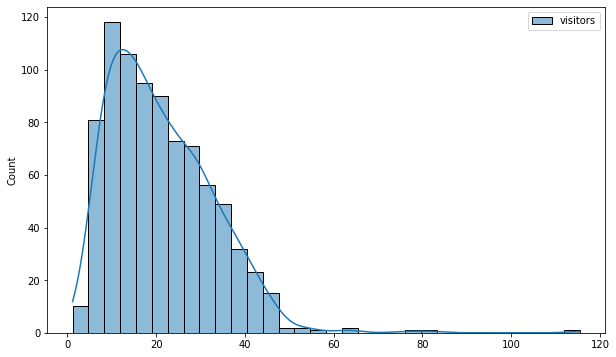

In [37]:
mean_visitor_by_res = air_visits.groupby('air_store_id').agg({'visitors':np.mean})
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

#### 식당 별 평균 방문자의 상자 그림

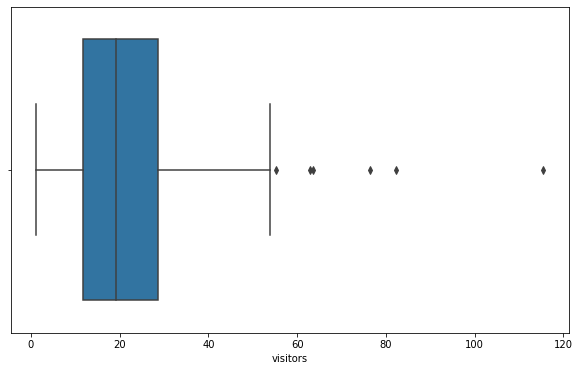

In [38]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_visitor_by_res['visitors'])
plt.show()

air_visit의 가게의 수:829개<br>
각 가게마다 평균 방문자 수를 보면 평균적으로 21명이 가게를 방문하며, 많게는 약 50~60명, 적게는 1명이다. 분포는 왼쪽으로 치우쳐 있는 형태를 가진다.



In [39]:
mean = pd.DataFrame(air_visits.groupby('air_store_id').agg({'visitors':np.mean}))
air_visits = pd.merge(air_visits, mean, how='left', on='air_store_id')
air_visits = air_visits.rename(columns={"visitors_x": "visitors", "visitors_y": "mean_visitors"}) # 컬럼명 mean_visitors로 변경

In [40]:
air_visits[air_visits['mean_visitors']> 54].air_store_id.unique()

array(['air_1c0b150f9e696a5f', 'air_df554c4527a1cfe6',
       'air_9c6787aa03a45586', 'air_258dc112912fc458',
       'air_789103bf53b8096b', 'air_900d755ebd2f7bbd'], dtype=object)

IQR 범위를 벗어난 이상치는 총 6개의 가게에서 확인할 수 있다.
- 'air_1c0b150f9e696a5f'
- 'air_df554c4527a1cfe6'
- 'air_9c6787aa03a45586'
- 'air_258dc112912fc458'
- 'air_789103bf53b8096b'
- 'air_900d755ebd2f7bbd'

In [41]:
air_visits[air_visits['air_store_id'] == 'air_1c0b150f9e696a5f']
air_visits[air_visits['air_store_id'] == 'air_df554c4527a1cfe6']
air_visits[air_visits['air_store_id'] == 'air_9c6787aa03a45586']
air_visits[air_visits['air_store_id'] == 'air_258dc112912fc458']
air_visits[air_visits['air_store_id'] == 'air_789103bf53b8096b']
air_visits[air_visits['air_store_id'] == 'air_900d755ebd2f7bbd']

,air_store_id,visit_date,visitors,day,dow,year,month,week,quarter,year_mth,mean_visitors
158186,air_900d755ebd2f7bbd,2017-03-02,4,2,3,2017,3,9,1,2017-3,82.2
158187,air_900d755ebd2f7bbd,2017-04-01,47,1,5,2017,4,13,2,2017-4,82.2
158188,air_900d755ebd2f7bbd,2017-04-02,54,2,6,2017,4,13,2,2017-4,82.2
158189,air_900d755ebd2f7bbd,2017-04-04,79,4,1,2017,4,14,2,2017-4,82.2
158190,air_900d755ebd2f7bbd,2017-04-05,82,5,2,2017,4,14,2,2017-4,82.2
158191,air_900d755ebd2f7bbd,2017-04-06,89,6,3,2017,4,14,2,2017-4,82.2
158192,air_900d755ebd2f7bbd,2017-04-07,84,7,4,2017,4,14,2,2017-4,82.2
158193,air_900d755ebd2f7bbd,2017-04-08,67,8,5,2017,4,14,2,2017-4,82.2
158194,air_900d755ebd2f7bbd,2017-04-09,50,9,6,2017,4,14,2,2017-4,82.2
158195,air_900d755ebd2f7bbd,2017-04-11,75,11,1,2017,4,15,2,2017-4,82.2


주말에 급격한 방문자 수의 증가가 평균에 영향을 미쳤다. 아직은 이 부분이 모델에 미칠 영향을 파악하기 어려우니 일단 보류..

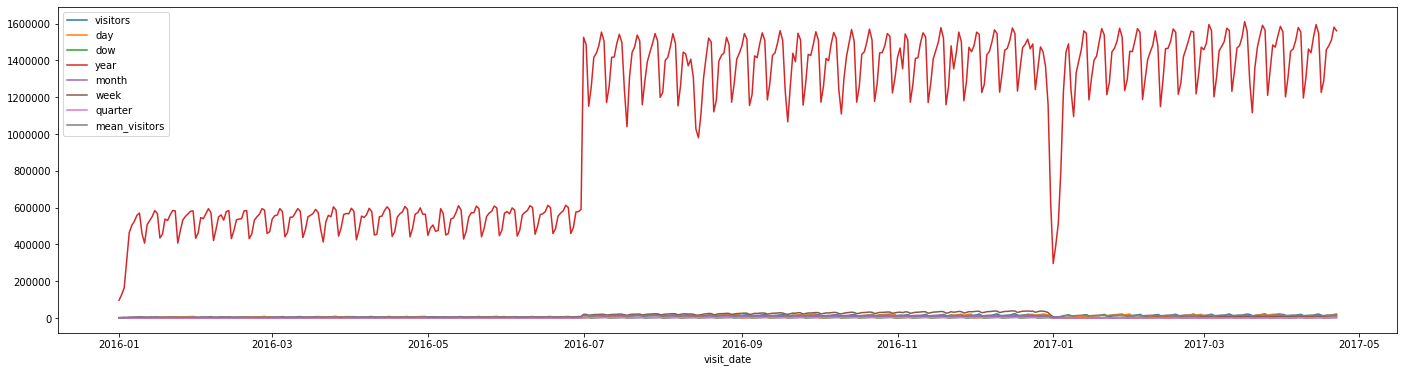

In [42]:
air_visits.groupby('visit_date').sum().plot(figsize=(24,6))

---

### 4.2 Hpg reserve

In [39]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [40]:
print('Total hpg reserve visitors - ',hpg_reserve['reserve_visitors'].sum())

Total hpg reserve visitors -  10149193


#### 레스토랑 별 평균 예약 방문자 수

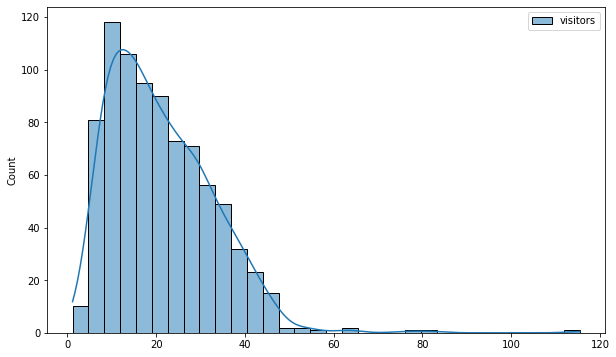

In [41]:
mean_reserve_byres = hpg_reserve.groupby('hpg_store_id').agg({'reserve_visitors':np.mean})
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(mean_visitor_by_res, kde=True)
plt.show()

In [42]:
mean_reserve_byres.describe()

,reserve_visitors
count,13325.000000
mean,5.990761
std,3.955656
min,1.192857
25%,3.967742
50%,5.125000
75%,6.915493
max,84.000000


#### 레스토랑 당 평균 예약 방문자  상자 그림

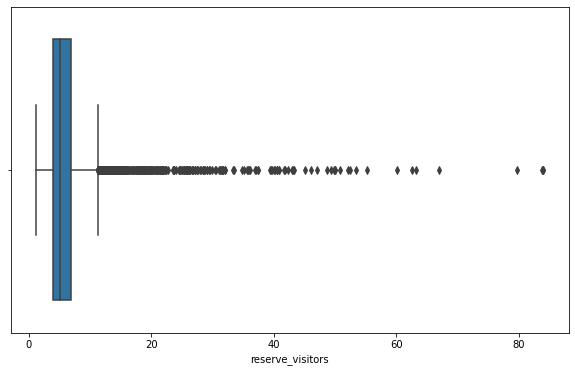

In [43]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(mean_reserve_byres['reserve_visitors'])
plt.show()

레스토랑 별 평균 예약 방문자 수는 5명 정도이며, 예약 방문자 수가 5~12명 사이인 예약 수가 많다.  
IQR범위인11.34명 이상인 예약이 575건이 있다. (전체 13325)

In [44]:
hpg_reserve = pd.merge(hpg_reserve, mean_reserve_byres, how='left', on='hpg_store_id')
hpg_reserve = hpg_reserve.rename(columns={"reserve_visitors_x": "reserve_visitors", "reserve_visitors_y": "mean_reserve_visitors"})

In [45]:
hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()
print(len(hpg_reserve[hpg_reserve['mean_reserve_visitors']> 11.34].hpg_store_id.unique()))

575


#### 방문 시각

In [46]:
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['visit_hour'] = hpg_reserve['visit_datetime'].dt.hour

In [47]:
time_reserve = hpg_reserve.groupby('visit_hour').agg({'reserve_visitors':np.sum})

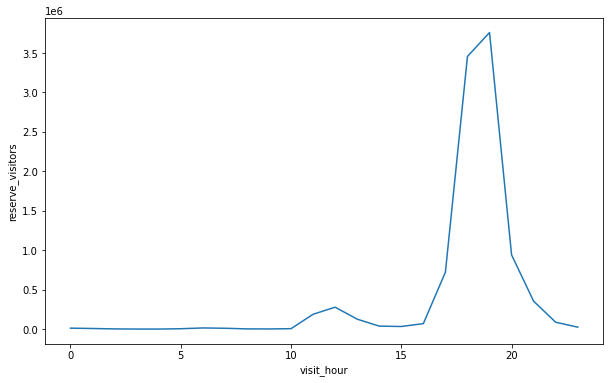

In [48]:
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='visit_hour', y='reserve_visitors', data=time_reserve)
plt.show()

저녁시간 예약이 많다

### 4.3 Hpg store

#### 장르별 레스토랑 시장 점유율

In [49]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [50]:
res_by_genre = pd.DataFrame(hpg_store.groupby(['hpg_genre_name'])['hpg_store_id'].value_counts()).groupby('hpg_genre_name').agg({'hpg_store_id':np.sum})
res_by_genre.sort_values(by='hpg_store_id', ascending=False)

,hpg_store_id
hpg_genre_name,
Japanese style,1750
International cuisine,700
Creation,410
Seafood,339
Grilled meat,325
Italian,249
Spain Bar/Italian Bar,229
Chinese general,91
Japanese food in general,85


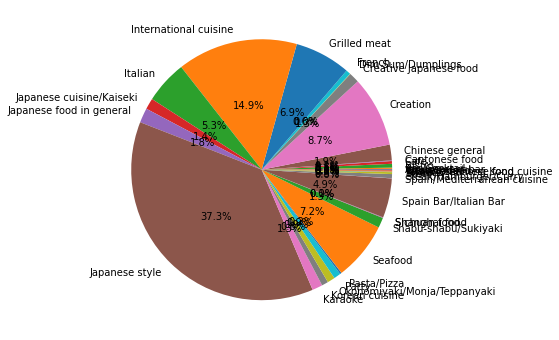

In [51]:
from matplotlib import pyplot as plt
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(res_by_genre['hpg_store_id'], labels=res_by_genre['hpg_store_id'].keys(), autopct='%0.1f%%',pctdistance=0.5)
plt.show()

hpg의 레스토랑은 34개의 장르로 세분화.  
Japanese style이 37.3%로 가장 많은 비중을 차지하고 International cusine 14.9%로 두 장르의 레스토랑이 전체의 50정도를 차지한다.

#### 장르별 예약자 수

In [52]:
hpg_full = pd.merge(hpg_reserve, hpg_store, how='left', on='hpg_store_id')
hpg_full.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,mean_reserve_visitors,visit_hour,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,4.947761,11,NaN,NaN,NaN,NaN
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2.381967,13,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,4.904040,16,NaN,NaN,NaN,NaN
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,8.312500,17,NaN,NaN,NaN,NaN
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,3.873950,17,NaN,NaN,NaN,NaN


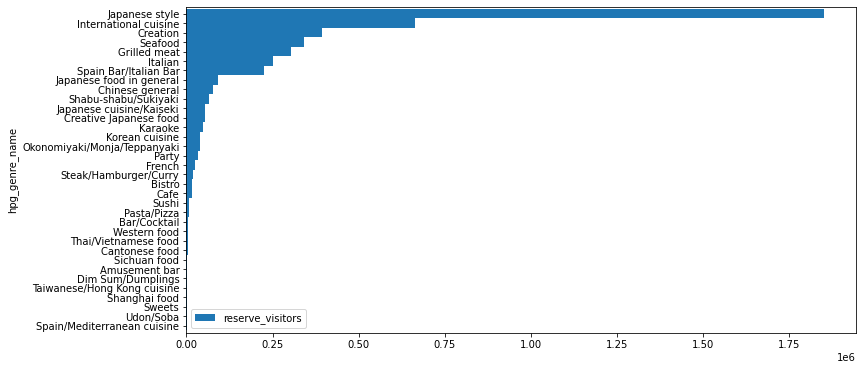

In [53]:
visitor_by_genre = hpg_full.groupby('hpg_genre_name').agg({'reserve_visitors':np.sum})
fig,ax = plt.subplots(figsize=(12,6))
visitor_by_genre.sort_values(by='reserve_visitors', ascending=True).plot(kind='barh', width=1,ax=ax)
plt.show()

레스토랑의 비중으로 본 인기 장르와 마찬가지로, 예약 방문객의 수도 japanase style, international cusine, creation, seafood, grilled meat 순으로 인기가 많다.

### 4.4 air_reserve
* Data 전처리  
날짜데이터를 연/월/일/요일 등으로 나눠준다.

In [43]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['day'] = air_reserve['visit_datetime'].dt.day
air_reserve['dow'] = air_reserve['visit_datetime'].dt.dayofweek
air_reserve['year'] = air_reserve['visit_datetime'].dt.year
air_reserve['month'] = air_reserve['visit_datetime'].dt.month
air_reserve['week'] = air_reserve['visit_datetime'].dt.week
air_reserve['quarter'] = air_reserve['visit_datetime'].dt.quarter
air_reserve['visit_date'] = air_reserve['visit_datetime'].dt.date
air_reserve['hour'] = air_reserve['visit_datetime'].dt.hour
air_reserve['year_mth'] = air_reserve['year'].astype(str)+'-'+air_reserve['month'].astype(str)

In [44]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,day,dow,year,month,week,quarter,visit_date,hour,year_mth
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00,1,1,4,2016,1,53,1,2016-01-01,19,2016-1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00,3,1,4,2016,1,53,1,2016-01-01,19,2016-1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00,6,1,4,2016,1,53,1,2016-01-01,19,2016-1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00,2,1,4,2016,1,53,1,2016-01-01,20,2016-1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 1:00,5,1,4,2016,1,53,1,2016-01-01,20,2016-1


#### 월 별 예약 추이  
* 각 월 별 몇명이 예약했는지 시각화
* 2016년의 예약은 저조한 편이고, 약 2016년 7월 부터 2016년 11월까지 예약이 없는 구간도 존재
* 2017년에 가까워질수록 예약이 폭발적으로 증가한다.
* 단, 2017년 1월에 예약이 급감하는 구간이 존재한다.

Text(0, 0.5, 'Reservation')

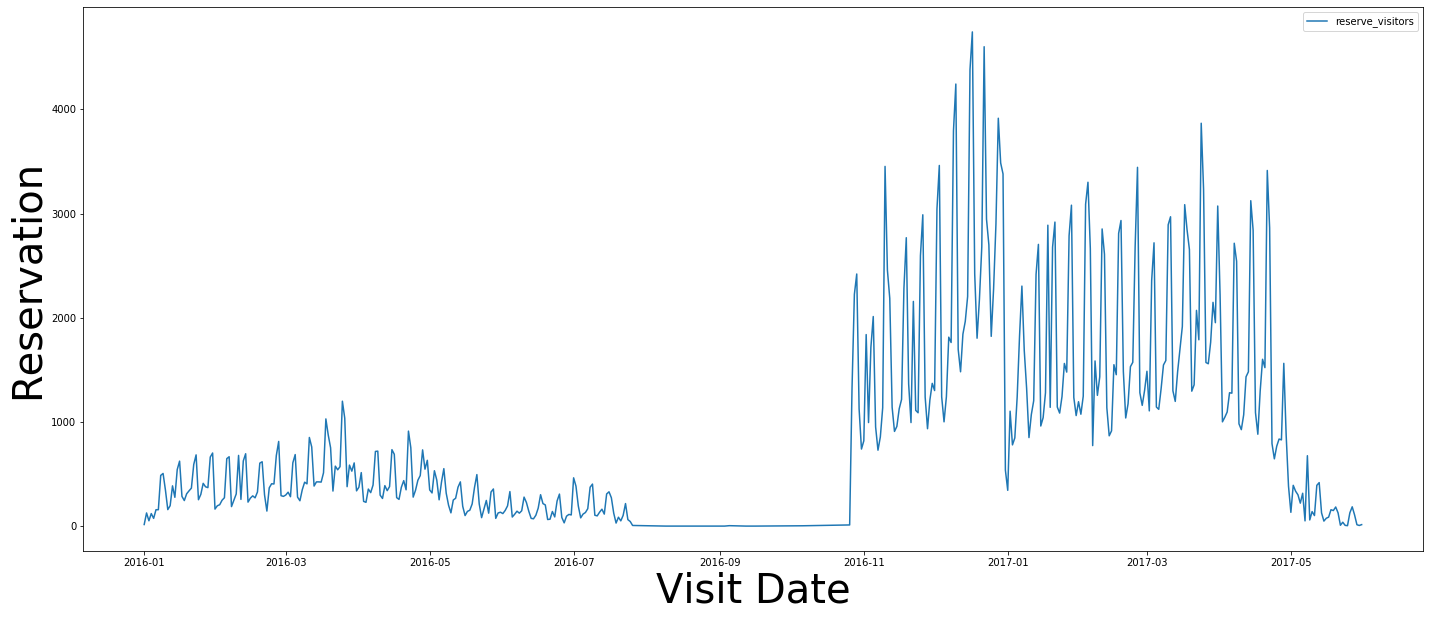

In [45]:
visitors_by_date = air_reserve.groupby(['visit_date']).agg({'reserve_visitors':np.sum})
fig, ax = plt.subplots(figsize=(24,10))
visitors_by_date.plot(kind='line', ax=ax)
plt.xlabel('Visit Date', fontsize = 40)
plt.ylabel('Reservation', fontsize = 40)

#### 예약 시간 추이
* 주로 저녁시간대에 예약을 하는 경우가 대다수를 차지한다.

Text(0, 0.5, 'Reservation')

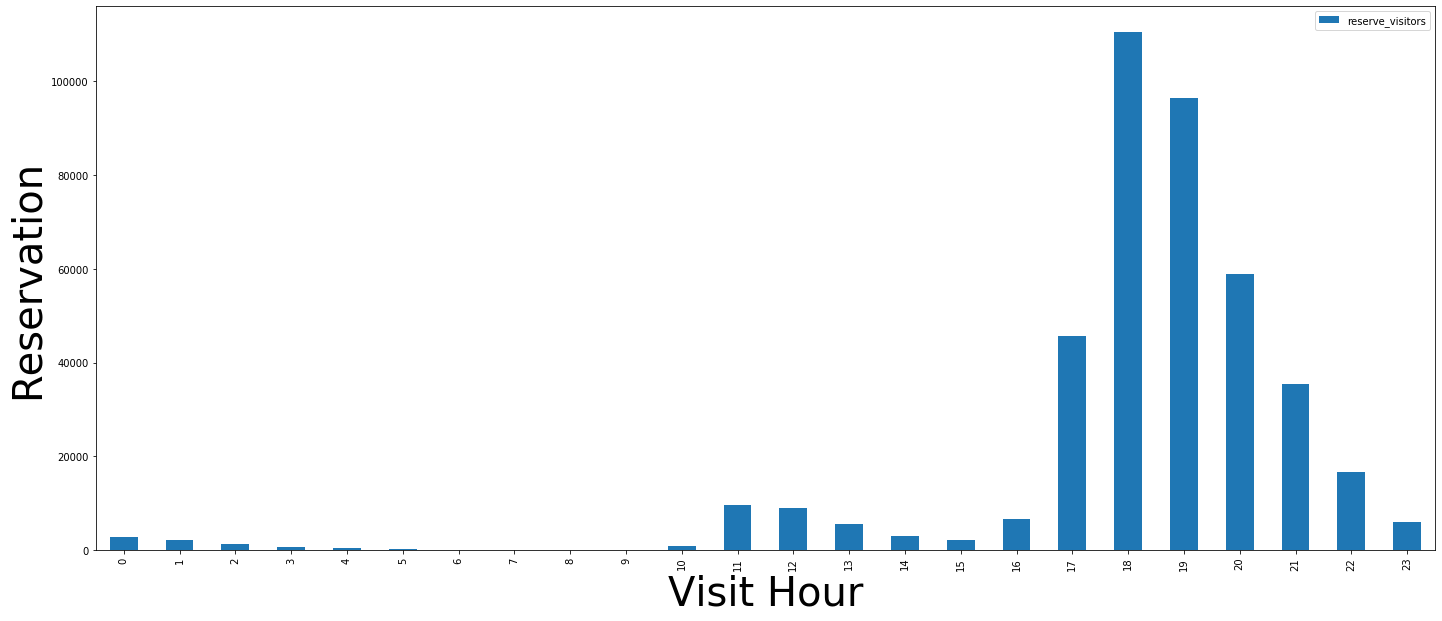

In [46]:
visitors_by_hour = air_reserve.groupby(['hour']).agg({'reserve_visitors':np.sum})
fig, ax = plt.subplots(figsize=(24,10))
visitors_by_hour.plot(kind='bar', ax=ax)
plt.xlabel('Visit Hour', fontsize = 40)
plt.ylabel('Reservation', fontsize = 40)

#### 예약 요일 추이
* 실제 방문자가 토,일요일에 많았던 것에 비해 예약은 월요일과 수요일, 금요일에 가장 많이 예약됐다.

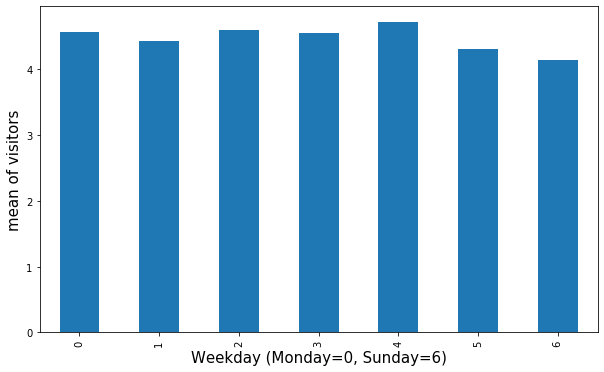

In [48]:
visitors_by_weekday = air_reserve.groupby('dow')['reserve_visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Weekday (Monday=0, Sunday=6)',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
plt.show()

#### 월 별 평균 예약 수 추이
* 2016년 8, 9월, 2017년 5월을 제외하고는 거의 비슷한 수준의 평균 예약 수를 보인다.
* 2016년의 예약이 없던 구간으로 인해 평균 예약 수가 낮게 측정된 것으로 보인다.
* 2016년 말부터 예약이 폭발적으로 증가했음에도 불구하고 월 별 평균은 적당한 수준을 유지한다.
* 단, 2017년 5월의 경우 다른 때 보다 2배정도 높은 예약률을 보인다.

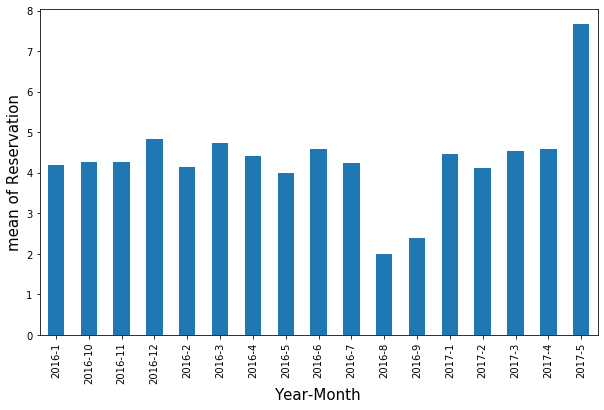

In [50]:
visitors_by_month = air_reserve.groupby('year_mth')['reserve_visitors'].mean()

fig,ax = plt.subplots(figsize=(10,6))
visitors_by_month.plot(kind='bar', ax=ax)
plt.xlabel('Year-Month',fontsize=15)
plt.ylabel('mean of Reservation',fontsize=15)
plt.show()

### 4.5 Air store

In [51]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


#### Mapping

In [52]:
def draw_map(df, title):
    plt.figure(figsize=(11,6))
    map = Basemap(resolution='i',llcrnrlon=127, urcrnrlon=147,
                  llcrnrlat=29, urcrnrlat=47, lat_0=0, lon_0=0,)
    map.shadedrelief()
    map.drawcoastlines()
    map.drawcountries(linewidth = 3)
    map.drawstates(color='0.3')
    parallels = np.arange(0.,360,10.,)
    map.drawparallels(parallels, labels = [True for s in range(len(parallels))])
    meridians = np.arange(0.,360,10.,)
    map.drawmeridians(meridians, labels = [True for s in range(len(meridians))])
    #______________________
    # put restaurants on map
    for index, (y,x) in df[['latitude','longitude']].iterrows():
        x, y = map(x, y)
        map.plot(x, y, marker='o', markersize = 5, markeredgewidth = 1, color = 'red',
                 markeredgecolor='k')
    plt.title(title, y = 1.05)

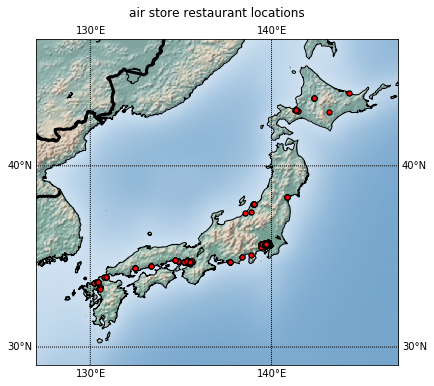

In [53]:
draw_map(air_store, 'air store restaurant locations')

#### 업종 별 가게 수

In [55]:
res_by_genre = pd.DataFrame(air_store.groupby(['air_genre_name'])['air_store_id'].value_counts()).groupby('air_genre_name').agg({'air_store_id':np.sum})
res_by_genre = res_by_genre.sort_values(by='air_store_id', ascending=False)
res_by_genre

,air_store_id
air_genre_name,
Izakaya,197
Cafe/Sweets,181
Dining bar,108
Italian/French,102
Bar/Cocktail,79
Japanese food,63
Other,27
Yakiniku/Korean food,23
Western food,16


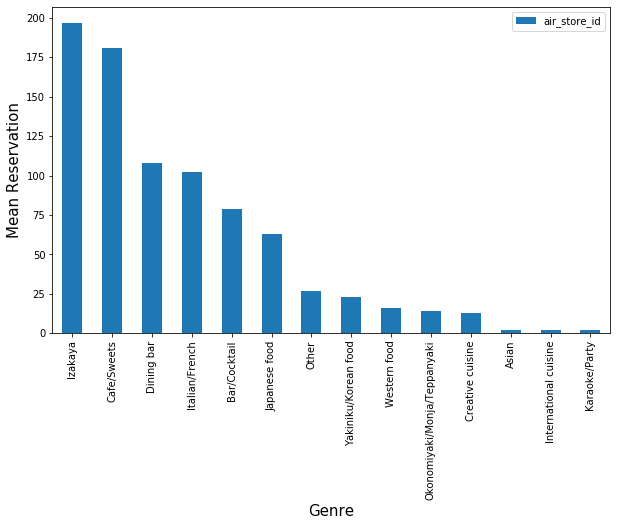

In [56]:
fig,ax = plt.subplots(figsize=(10,6))
res_by_genre.plot(kind='bar', ax=ax)
plt.xlabel('Genre',fontsize=15)
plt.ylabel('Mean Reservation',fontsize=15)
plt.show()

#### 지역 별 가게 수

In [58]:
res_by_area = pd.DataFrame(air_store.groupby(['air_area_name'])['air_store_id'].value_counts()).groupby('air_area_name').agg({'air_store_id':np.sum})
res_by_area = res_by_area.sort_values(by='air_store_id', ascending=False)
res_by_area

,air_store_id
air_area_name,
Fukuoka-ken Fukuoka-shi Daimyō,64
Tōkyō-to Shibuya-ku Shibuya,58
Tōkyō-to Minato-ku Shibakōen,51
Tōkyō-to Shinjuku-ku Kabukichō,39
Tōkyō-to Setagaya-ku Setagaya,30
...,...
Tōkyō-to Shibuya-ku Dōgenzaka,2
Tōkyō-to Shibuya-ku Higashi,2
Tōkyō-to Shibuya-ku Jingūmae,2


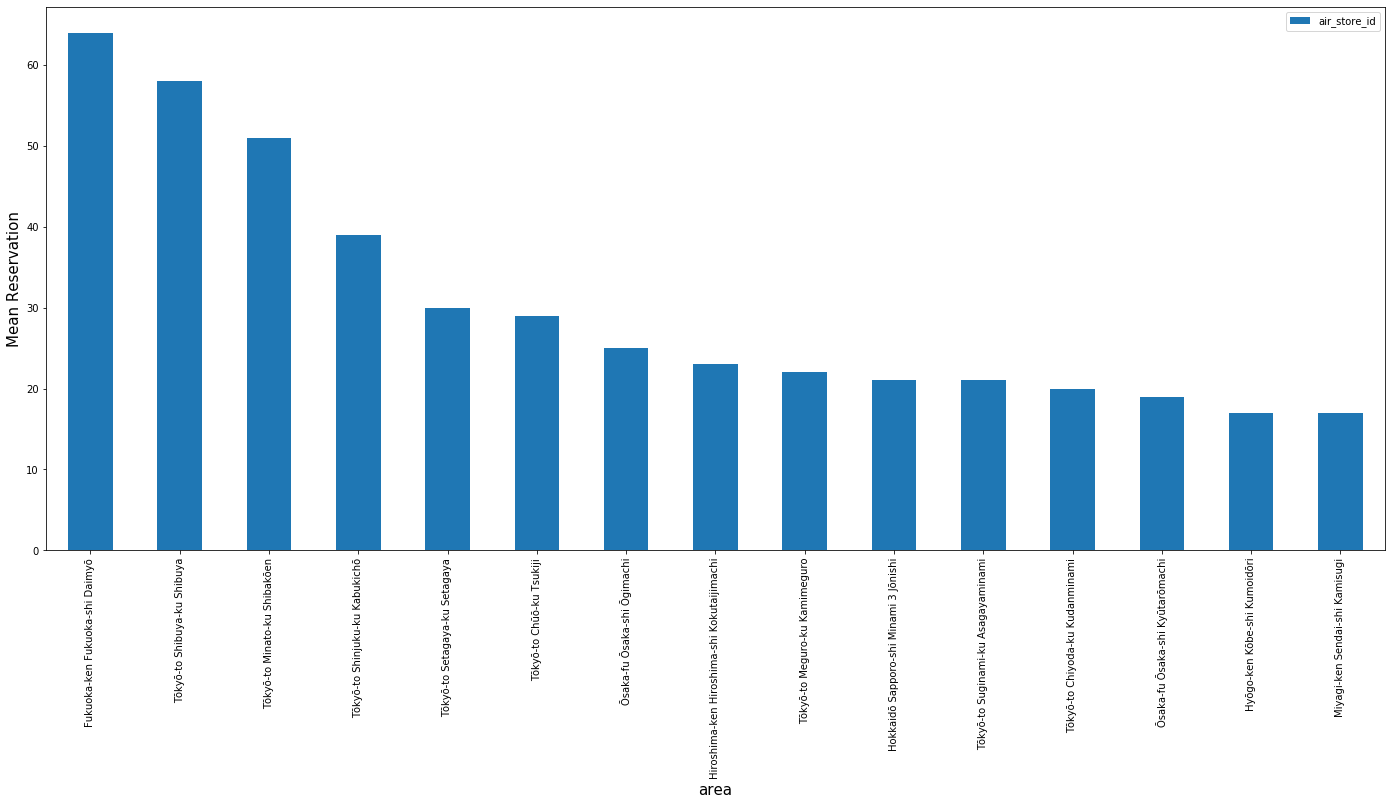

In [59]:
fig,ax = plt.subplots(figsize=(24,10))
res_by_area.head(15).plot(kind='bar', ax=ax)
plt.xlabel('area',fontsize=15)
plt.ylabel('Mean Reservation',fontsize=15)
plt.show()

### 4.6 Holiday

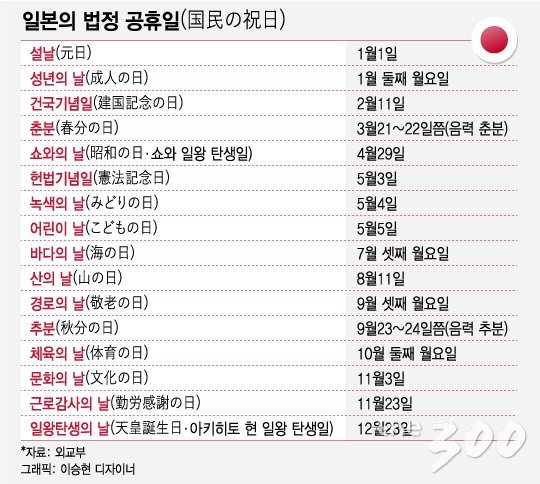
* 일본 공휴일의 특징   
  * 일요일과 공휴일이 겹칠 경우 그 다음 평일을 휴일로 하는 대체 휴일 제도를 실시하고 있다
  * 공휴일중에서 성인의 날, 바다의 날, 경로의 날, 체육의 날은 해피 먼데이 제도가 적용되어 항상 월요일이다.
  * 매년 4월말-5월 초 즈음 골든위크가 있습니다.   
      2016 : 4/27-5/5   
      2017 : 4/27-5/5
* 생각해볼만한 것
    * 학습 데이터로 사용할 수 없는 날짜, 문자열타입은 나중에 계산 가능한 타입으로 변경해야할 것 같다
    * day_of_week같은 범주형 데이터는 Label Encoding이나 One-Hot Encoding을 사용?
    * x월 x일 처럼 지정된 휴일 외에 'x월 x째 x요일' 같은 휴일()이 있기 때문에 몇째주인지에 대한 정보도 추가되면 좋을 듯?   
    * 음력을 고려할 필요가 있을까?
    * 일반 휴일보다 연휴일 때는 방문자가 더 많을까?

#### air_visit_data와 date_info의 관계

In [62]:
air_visit_with_date_info = pd.merge(air_visits, date_info, left_on="visit_date", right_on="calendar_date")
air_visit_with_date_info.drop(["calendar_date"], axis=1, inplace=True)
air_visit_with_date_info.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,21,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0


#### 요일에 따라 방문자의 수가 달라질까?

<AxesSubplot:xlabel='visit_day_of_week'>

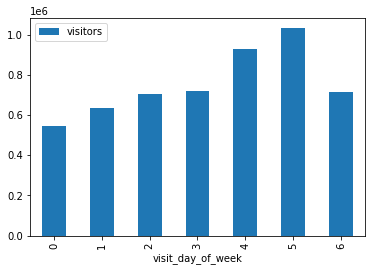

In [63]:
air_visit_with_date_info['visit_day_of_week'] = pd.to_datetime(air_visit_with_date_info['visit_date']).dt.dayofweek

air_visit_with_date_info.loc[:,["visit_day_of_week", "visitors"]] \
                            .groupby("visit_day_of_week") \
                            .sum() \
                            .plot(kind="bar")


* 금/토 요일에 방문자가 많고 월요일 방문자가 적다
* 일요일은 생각보다 방문자가 특별히 많지 않다
* 휴일보다 휴일 전날에 방문자가 많은 것은 아닐까? (저녁약속?)
* 월요일이 특히 방문자가 적은 것은 휴일 다음날이기 때문일까?   
  만약 그렇다면 일요일이 아닌 휴일 다음날도 방문자가 적을까?

#### 평일과 주말의 평균 방문자는 차이가 날까?

<AxesSubplot:>

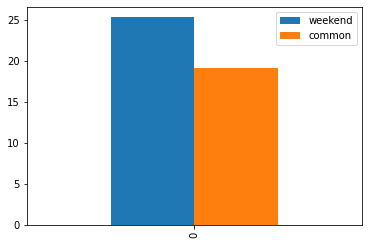

In [64]:
# 토/일요일을 주말로 분류
air_visit_with_date_info['weekend_flg'] = ((air_visit_with_date_info['visit_day_of_week']>4)).astype(int)

temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 0 & weekend_flg == 0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

temp_df.plot(kind="bar")

#### 금-토요일이 토-일요일보다 평균 방문자가 많은가?

<AxesSubplot:>

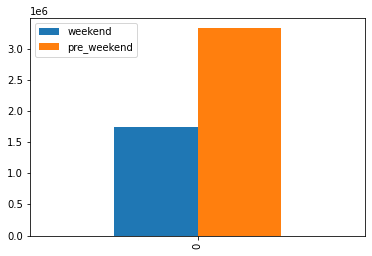

In [65]:
air_visit_with_date_info['pre_weekend_flg'] = ((air_visit_with_date_info['visit_day_of_week']>3) & (air_visit_with_date_info['visit_day_of_week']<6)).astype(int)

temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].sum()]

query = "pre_weekend_flg == 0"
temp_df["pre_weekend"] = [air_visit_with_date_info.query(query)["visitors"].sum()]

temp_df.plot(kind="bar")

* 주말보다 금-토요일이 방문자 수가 훨씬 많다(가라오케나 술집 등의 영향인가?)

#### 주말이 아닌 공휴일에는 평균적으로 방문자가 많을까?

<AxesSubplot:>

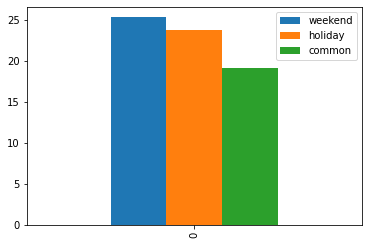

In [66]:
temp_df = pd.DataFrame()

query = "weekend_flg == 1"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 1"
temp_df["holiday"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

query = "holiday_flg == 0 & weekend_flg == 0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]

temp_df.plot(kind="bar")

* 평일에 비하면 공휴일에 방문자가 더 많다
* 주말 > 휴일 > 평일 순으로 방문객이 많다.

#### 휴일 전날은 금-토의 사례처럼 방문자가 많을까?

<AxesSubplot:>

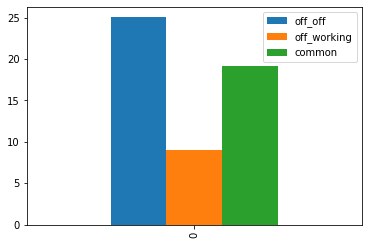

In [67]:
air_visit_with_date_info['off_day_flg'] = ((air_visit_with_date_info['weekend_flg']==1) | (air_visit_with_date_info['holiday_flg']==1)).astype(int)
air_visit_with_date_info['next_day_is_off_day'] = air_visit_with_date_info['off_day_flg'].shift(-1,fill_value=0).astype(int)

temp_df = pd.DataFrame()

query = "next_day_is_off_day == 1"
temp_df["off_off"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "off_day_flg == 1 & next_day_is_off_day==0"
temp_df["off_working"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "off_day_flg == 0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]


temp_df.plot(kind="bar")

* 다음날이 휴일인 경우 방문자가 많았다
* 오늘이 휴일인데 다음날이 휴일이 아닌 경우 평균적으로 방문자가 적었다

#### 골든위크에는 다른 휴일들보다 방문자가 더 많을까?
* 2016년 골든위크는 4/27-5/5

<AxesSubplot:>

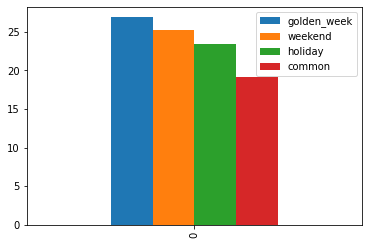

In [68]:
air_visit_with_date_info['off_day_flg'] = ((air_visit_with_date_info['weekend_flg']==1) | (air_visit_with_date_info['holiday_flg']==1)).astype(int)

air_visit_with_date_info['golden_week_flg'] = ((air_visit_with_date_info['visit_date']>='2016-04-29') & (air_visit_with_date_info['visit_date']<='2016-05-05')).astype(int)

temp_df = pd.DataFrame()

query = "golden_week_flg == 1"
temp_df["golden_week"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "weekend_flg == 1 & golden_week_flg==0"
temp_df["weekend"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "holiday_flg == 1 & golden_week_flg==0"
temp_df["holiday"] = [air_visit_with_date_info.query(query)["visitors"].mean()]
query = "off_day_flg == 0 & golden_week_flg==0"
temp_df["common"] = [air_visit_with_date_info.query(query)["visitors"].mean()]


temp_df.plot(kind="bar")

* 골든위크 기간에는 그렇지 않은 휴일보다 특히 더 많은 방문자가 방문한다는 것을 알 수 있다.

#### 연휴에는 방문자가 더 많을까?

<AxesSubplot:>

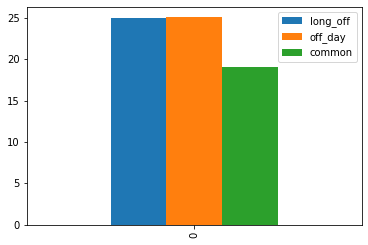

In [69]:
# 3일 이상 연속으로 쉴 경우 연휴로 판단합니다
date_info['day_of_week'] = pd.to_datetime(date_info['calendar_date']).dt.dayofweek
date_info['weekend_flg'] = ((date_info['day_of_week']>4)).astype(int)
date_info['off_day_flg'] = ((date_info['weekend_flg']==1) | (date_info['holiday_flg']==1)).astype(int)


def true_runs(a):
    iszero = np.concatenate(([0], np.equal(a, 1).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

date_info['long_off_flg'] = 0
continues_off_list = true_runs(date_info['off_day_flg'])

for i in continues_off_list:
    if i[1]-i[0]>=3:
        date_info.loc[i[0]:i[1]-1,'long_off_flg'] = 1
        
air_visit_with_long_off_info = pd.merge(air_visits, date_info, left_on="visit_date", right_on="calendar_date")
air_visit_with_long_off_info.drop(["calendar_date"], axis=1, inplace=True)
air_visit_with_long_off_info.head()

temp_df = pd.DataFrame()

query = "long_off_flg == 1"
temp_df["long_off"] = [air_visit_with_long_off_info.query(query)["visitors"].mean()]
query = "off_day_flg == 1 & long_off_flg==0"
temp_df["off_day"] = [air_visit_with_long_off_info.query(query)["visitors"].mean()]
query = "off_day_flg == 0"
temp_df["common"] = [air_visit_with_long_off_info.query(query)["visitors"].mean()]


temp_df.plot(kind="bar")

* 연휴라고 다른 휴일들보다 방문자가 많지는 않다

#### date_info 데이터를 살펴본 결과
* 금/토 요일에 방문자가 많고 월요일 방문자가 적다
* 평균적으로 평일에 비하면 주말에 방문자가 더 많다
* 평균적으로 평일에 비하면 공휴일에 방문자가 더 많다
* 평균적으로 주말 > 휴일 > 평일 순으로 방문객이 많다.
* 평균적으로 골든위크 기간에는 그렇지 않은 휴일보다 특히 더 많은 방문자가 방문한다.
* 연휴라고 다른 휴일들보다 방문자가 많지는 않다
* 다음 날이 휴일인 경우 그렇지 않은 날들보다 방문자가 더 많았다
* 다음날이 주말인 경우 방문자가 많았다
* 오늘이 휴일인데 다음날이 휴일이 아닌 경우 평균적으로 방문자가 적었다

## 5. Modeling

### Load libraries

In [24]:
# import libraries
import time
import calendar
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import os

%matplotlib inline

# config
DATA_DIR = './data/'

# define utility funtions
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

calendar.setfirstweekday(6)
def get_week_of_month(date_str):
    year = int(date_str[:4])
    month = int(date_str[5:7])
    day = int(date_str[8:10])
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)

### Load data

In [25]:
# 데이터 로드
air_visit = pd.read_csv(os.path.join(DATA_DIR, 'air_visit_data.csv'))
air_reserve = pd.read_csv(os.path.join(DATA_DIR, 'air_reserve.csv'))
hpg_reserve = pd.read_csv(os.path.join(DATA_DIR, 'hpg_reserve.csv'))
air_store = pd.read_csv(os.path.join(DATA_DIR, 'air_store_info.csv'))
hpg_store = pd.read_csv(os.path.join(DATA_DIR, 'hpg_store_info.csv'))
store_id_map = pd.read_csv(os.path.join(DATA_DIR, 'store_id_relation.csv'))
date_info = pd.read_csv(os.path.join(DATA_DIR, 'date_info.csv'))
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [26]:
# 전처리를 한번에 하기위해 위해 데이터 합치기
air_visit_count = len(air_visit)

train_data = air_visit.copy()
test_data = submission.copy()

test_data["air_store_id"] = test_data.apply(lambda x: '_'.join(x['id'].split('_')[:2]), axis=1)
test_data["visit_date"] = test_data.apply(lambda x:x['id'].split("_")[-1], axis=1)
test_data.drop("id",axis=1, inplace=True)

concat_data = pd.concat([train_data, test_data])
concat_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0
32015,air_fff68b929994bfbd,2017-05-28,0
32016,air_fff68b929994bfbd,2017-05-29,0
32017,air_fff68b929994bfbd,2017-05-30,0


### Merge tables

### holiday

In [27]:
# 학습시킬 데이터에 holidays 데이터 merge
concat_data = pd.merge(concat_data, date_info, how="left", left_on="visit_date", right_on="calendar_date")
concat_data.drop("calendar_date", axis=1, inplace=True)
concat_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


### merge store_info

In [28]:
print(len(air_store))
print(len(store_id_map))

829
150


* air_store와 매칭이 되는 hpg_store의 갯수가 150개밖에 되지 않는다. 나중에 결측치 처리가 필요할 듯

In [29]:
concat_data = pd.merge(concat_data, air_store, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, store_id_map, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, hpg_store, how="left", on="hpg_store_id")
concat_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


### merge reservation

In [30]:
# 예약데이터는 visit_date 기준으로 air, hpg에서의 예약이 각각 몇팀 있는지, 예약인원은 몇명인지 데이터를 merge
air_reserve_data = air_reserve.copy()
air_reserve_data["visit_datetime"] = air_reserve_data["visit_datetime"].str[:10]
air_reserve_data = air_reserve_data[["air_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["air_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
air_reserve_data = air_reserve_data.rename(columns = {'reserve_visitors': 'air_reserve_visitors'})
air_reserve_data = air_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})

pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])
 
concat_data = pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])

In [31]:
hpg_reserve_data = hpg_reserve.copy()
hpg_reserve_data["visit_datetime"] = hpg_reserve_data["visit_datetime"].str[:10]
hpg_reserve_data = hpg_reserve_data[["hpg_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["hpg_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
hpg_reserve_data = hpg_reserve_data.rename(columns = {'reserve_visitors': 'hpg_reserve_visitors'})
hpg_reserve_data = hpg_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})
hpg_reserve_data["visit_date"] = hpg_reserve_data["visit_date"].str[:10]

concat_data = pd.merge(concat_data, hpg_reserve_data, how="left", on=['hpg_store_id', 'visit_date'])

In [32]:
concat_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_reserve_visitors,hpg_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 결측치 처리

In [33]:
concat_data.isna().sum()

air_store_id                 0
visit_date                   0
visitors                     0
day_of_week                  0
holiday_flg                  0
air_genre_name               0
air_area_name                0
latitude_x                   0
longitude_x                  0
hpg_store_id            232258
hpg_genre_name          261572
hpg_area_name           261572
latitude_y              261572
longitude_y             261572
air_reserve_visitors    254932
hpg_reserve_visitors    270247
dtype: int64

In [34]:
# 중복되는 피쳐 제거
concat_data = concat_data.drop(["hpg_area_name", "hpg_genre_name", "latitude_y", "longitude_y"], axis=1)

In [36]:
query = "air_reserve_visitors.notnull() and hpg_reserve_visitors.notnull() and air_reserve_visitors!=hpg_reserve_visitors"
concat_data.query(query,engine='python').head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors
4669,air_3e93f3c81008696d,2016-10-27,48,Thursday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,12.0,2.0
4670,air_3e93f3c81008696d,2016-10-28,25,Friday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,4.0,2.0
4671,air_3e93f3c81008696d,2016-10-29,42,Saturday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,17.0,28.0
4673,air_3e93f3c81008696d,2016-11-01,76,Tuesday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,74.0,3.0
4676,air_3e93f3c81008696d,2016-11-04,5,Friday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,11.0,7.0


In [37]:
query = "air_reserve_visitors.notnull() and hpg_reserve_visitors.notnull() and air_reserve_visitors==hpg_reserve_visitors"
concat_data.query(query,engine='python').head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors
4678,air_3e93f3c81008696d,2016-11-07,9,Monday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,2.0,2.0
4728,air_3e93f3c81008696d,2017-01-10,9,Tuesday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,2.0,2.0
4748,air_3e93f3c81008696d,2017-02-06,46,Monday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,4.0,4.0
4778,air_3e93f3c81008696d,2017-03-13,90,Monday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,26.0,26.0
4796,air_3e93f3c81008696d,2017-04-03,12,Monday,0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,hpg_c2a8494d55fafbd6,8.0,8.0


* air_reserve_visitors와 hpg_reserve_visitors가 같은 날이 꽤 많은 점이 이상하지만 다른 날이 2배 이상이기 때문에 일단 넘어간다

### 데이터 전처리

In [38]:
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   air_store_id          284127 non-null  object 
 1   visit_date            284127 non-null  object 
 2   visitors              284127 non-null  int64  
 3   day_of_week           284127 non-null  object 
 4   holiday_flg           284127 non-null  int64  
 5   air_genre_name        284127 non-null  object 
 6   air_area_name         284127 non-null  object 
 7   latitude_x            284127 non-null  float64
 8   longitude_x           284127 non-null  float64
 9   hpg_store_id          51869 non-null   object 
 10  air_reserve_visitors  29195 non-null   float64
 11  hpg_reserve_visitors  13880 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 28.2+ MB


* air_store_id, visit_date, day_of_week, air_genre_name, air_area_name 컬럼은 연산을 할 수 없는 데이터 형태로 되어있다

In [39]:
# dayofweek : monday(0)~sunday(6)
# 날짜데이터 변환
concat_data['visit_date'] = pd.to_datetime(concat_data['visit_date'])
concat_data['visit_day_of_week'] = pd.to_datetime(concat_data['visit_date']).dt.dayofweek
concat_data['day'] = concat_data['visit_date'].dt.day
concat_data['dow'] = concat_data['visit_date'].dt.weekday # monday:0, sunday:6
concat_data['year'] = concat_data['visit_date'].dt.year
concat_data['month'] = concat_data['visit_date'].dt.month
concat_data['week'] = concat_data['visit_date'].dt.week
concat_data['quarter'] = concat_data['visit_date'].dt.quarter
concat_data['visit_date'] = concat_data['visit_date'].dt.date

# 주말 데이터 추가 
concat_data['weekend_flg'] = ((concat_data['visit_day_of_week']>4)).astype(int)

# 일본 휴일의 특성(해피먼데이)상 날짜가 해당 월 몇째주인지에 대한 데이터를 추가합니다
concat_data["visit_week_of_month"] = concat_data["visit_date"].apply(str).apply(get_week_of_month)

# 요일을 원핫인코딩
concat_data = pd.get_dummies(concat_data, columns = ['day_of_week'], prefix="", prefix_sep='')

# 주말/공휴일 관계 없이 쉬는 날에 대한 컬럼 추가
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)

# 다음날이 휴일인지 판단할 수 있는 컬럼 추가
concat_data['next_day_is_off'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

# 골든위크 플래그 추가
# 2016 골든위크는 4/29~5/5일
# 2017 골든위크는 4/29~5/5일
concat_data['golden_week_flg'] = ( \
                                  ((concat_data['visit_date'].apply(str)>='2016-04-29') & (concat_data['visit_date'].apply(str)<='2016-05-05')) | \
                                  ((concat_data['visit_date'].apply(str)>='2017-04-29') & (concat_data['visit_date'].apply(str)<='2017-05-05'))
                                 ).astype(int)

concat_data.head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,off_day_flg,next_day_is_off,golden_week_flg
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# 상점별 각 요일 방문자 통계를 feature로 추가

unique_stores = test_data['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
# store_7days
# air_store_id : 각 상점의 고유값
# dow : 요일(0~6)

# store_7days
store_sum = pd.DataFrame({'air_store_id': unique_stores})

# mapping concat data dow to stores(test data) - min, mean, median, max, count 
tmp = concat_data.groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# store_7days
# concat_data
concat_data = pd.merge(concat_data, store_7days, how='left', on=['air_store_id','dow'])

concat_data["total_visitors"] = concat_data["total_visitors"].fillna(0)
concat_data["mean_visitors"] = concat_data["mean_visitors"].fillna(0)
concat_data["median_visitors"] = concat_data["median_visitors"].fillna(0)
concat_data["max_visitors"] = concat_data["max_visitors"].fillna(0)
concat_data["count_observations"] = concat_data["count_observations"].fillna(0)

In [41]:
# 상점별 직전 분기 대비 증감율 피쳐 추가
qoq= concat_data.groupby(['air_store_id','year','quarter'])['visitors'].sum()
qoq=qoq.unstack(0)
qoq=pd.DataFrame(qoq.to_records())
qoq=qoq.transpose()
qoq.drop(['year','quarter'],inplace=True)
qoq['2016Q2']=qoq[1]/qoq[0]*100
qoq['2016Q3']=qoq[2]/qoq[1]*100
qoq['2016Q4']=qoq[3]/qoq[2]*100
qoq['2017Q1']=qoq[4]/qoq[3]*100
lst=['2016Q2','2016Q3','2016Q4','2017Q1']
qoq=qoq[lst]
qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1) 
qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)
qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)
qoq.index.names=['air_store_id']
qoq.reset_index(inplace=True)
qoq = qoq.fillna(0) #change to one for algo training

concat_data = pd.merge(concat_data, qoq, how='left', on='air_store_id')

In [42]:
# 금/토요일인지? (EDA 참고)
concat_data['pre_weekend_flg'] = ((concat_data['visit_day_of_week']>3) & (concat_data['visit_day_of_week']<6)).astype(int)

# 휴일의 전 날인지? (EDA 참고)
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)
concat_data['next_day_is_off_day'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

# 다음 날이 평일인 휴일인지 (EDA 참고)
concat_data["today_off_next_day_working"] =  ((concat_data['off_day_flg']==1) | (concat_data['next_day_is_off_day']==0)).astype(int)


In [43]:
# air_genre_name 처리

# 원핫인코딩
concat_data = pd.get_dummies(concat_data, columns = ['air_genre_name'], prefix="", prefix_sep='')

# Label Encoding
# le = LabelEncoder()
# concat_data["en_air_genre_name"] = le.fit_transform(concat_data['air_genre_name'])
# concat_data = concat_data.drop("air_genre_name", axis=1)
# concat_data.head()

In [44]:
# air_area_name 처리

concat_data["area_1"] = concat_data["air_area_name"].str.split(" ").str[0]
concat_data["area_2"] = concat_data["air_area_name"].str.split(" ").str[1]
concat_data["area_3"] = concat_data["air_area_name"].str.split(" ").str[2]

concat_data = pd.get_dummies(concat_data, columns = ['area_1'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_2'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_3'], prefix="", prefix_sep='')

# le1 = LabelEncoder()
# concat_data["en_area_1"] = le1.fit_transform(concat_data['area_1'])
# le2 = LabelEncoder()
# concat_data["en_area_2"] = le2.fit_transform(concat_data['area_2'])
# le3 = LabelEncoder()
# concat_data["en_area_3"] = le3.fit_transform(concat_data['area_3'])

concat_data.head()

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,air_ba937bf13d40fb24,2016-01-13,25,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### 이상치 확인

In [50]:
# visitors의 분포가 약간 이상해 보여서 데이터를 확인해봅니다
air_visit.sort_values(by="visitors", ascending=False).head()

,air_store_id,visit_date,visitors
85314,air_cfdeb326418194ff,2017-03-08,877
214825,air_8c3175aa5e4fc569,2017-04-18,777
72836,air_f2985de32bb792e0,2016-07-10,675
172123,air_eca5e0064dc9314a,2016-08-30,627
143894,air_43d577e0c9460e64,2016-01-24,514


* 한 상점의 방문자만 특별히 높다(이상치)기 보다는 방문자가 많은 레스토랑이 몇 곳 있는 것 같습니다   
    visitors는 타겟 데이터이기 때문에 train / test 데이터를 분리한 후 정규화가 필요할 것으로 보입니다.

In [ ]:
# air_reserve_visitors의 분포도 약간 이상해 보여서 데이터를 확인해봅니다
concat_data.sort_values("air_reserve_visitors").tail()

* air_stor_id가 air_e7fbee4e3cfe65c5 2017월 02월 05일에 예약자가 너무 많아보입니다. 이상치인지 확인해봅니다

In [53]:
query = "air_store_id=='air_e7fbee4e3cfe65c5' and visit_datetime.str.contains('2017-02-05')"
air_reserve.query(query, engine="python")

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
58288,air_e7fbee4e3cfe65c5,2017-02-05 17:00:00,2016-09-05 13:00:00,7
58289,air_e7fbee4e3cfe65c5,2017-02-05 17:00:00,2016-09-06 16:00:00,3
58290,air_e7fbee4e3cfe65c5,2017-02-05 17:00:00,2016-09-18 00:00:00,6
58291,air_e7fbee4e3cfe65c5,2017-02-05 17:00:00,2016-09-22 20:00:00,3
58292,air_e7fbee4e3cfe65c5,2017-02-05 17:00:00,2016-09-05 21:00:00,8
...,...,...,...,...
58745,air_e7fbee4e3cfe65c5,2017-02-05 23:00:00,2016-03-29 14:00:00,12
58746,air_e7fbee4e3cfe65c5,2017-02-05 23:00:00,2016-04-03 16:00:00,10
58747,air_e7fbee4e3cfe65c5,2017-02-05 23:00:00,2016-04-17 23:00:00,2
58748,air_e7fbee4e3cfe65c5,2017-02-05 23:00:00,2016-04-05 23:00:00,3


* 실제로 많은 인원이 방문했던 것 같습니다.. 2016년 4월에 예약한 사람도 있는걸 보니 인기있는 식당인가봅니다
* 데이터 중 대부분이 0인 경우 nomalization을 어떻게 하는게 좋을까?

In [55]:
# hpg_reserve_visitors 데이터도 확인해봅니다
concat_data.sort_values("hpg_reserve_visitors").tail()

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
284122,air_fff68b929994bfbd,2017-05-27,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284123,air_fff68b929994bfbd,2017-05-28,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284124,air_fff68b929994bfbd,2017-05-29,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284125,air_fff68b929994bfbd,2017-05-30,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
284126,air_fff68b929994bfbd,2017-05-31,0,0,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [56]:
query = "hpg_store_id=='hpg_08def9f764fcca4c' and visit_datetime.str.contains('2016-12-17')"
hpg_reserve.query(query, engine="python")

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
1178936,hpg_08def9f764fcca4c,2016-12-17 19:00:00,2016-11-09 18:00:00,35
1188064,hpg_08def9f764fcca4c,2016-12-17 21:00:00,2016-11-09 21:00:00,35
1188065,hpg_08def9f764fcca4c,2016-12-17 21:00:00,2016-11-09 18:00:00,35
1188066,hpg_08def9f764fcca4c,2016-12-17 21:00:00,2016-11-22 23:00:00,38
1188741,hpg_08def9f764fcca4c,2016-12-17 22:00:00,2016-12-12 14:00:00,14


* 역시 단체 손님이 많았던 날로 정상적인 테이터인 것 처럼 보입니다

### train / test 데이터 분리

In [58]:
# 연산에 사용할 데이터만 분리해줍니다
without_columns = ["air_store_id", "visit_date", "day_of_week", "visit_day_of_week", "air_area_name", "hpg_store_id", "area_1", "area_2", "area_3"]
selected_columns = [x for x in concat_data.columns if x not in without_columns]
# list(concat_data.columns)# - without_columns
train_data = concat_data[selected_columns]
# train_data = concat_data[]
# train_data.head()

In [60]:
# train, val, test 데이터를 나눕니다
x_train = train_data[:air_visit_count]
x_test = train_data[air_visit_count:]

y_train = x_train["visitors"]
x_train = x_train.drop("visitors", axis=1)
x_test = x_test.drop("visitors", axis=1)

# validation 데이터가 필요할 경우 train_test_split을 사용해 나눠줍니다
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=False, test_size = 0.2)

print(x_train.head(2))
print("==============================")
print(y_train.head(2))
print("==============================")
# print(x_val.head(2))
# print("==============================")
# print(y_val.head(2))
# print("==============================")
print(x_test.head(2))

   holiday_flg  latitude_x  longitude_x  air_reserve_visitors  \
0            0   35.658068   139.751599                   NaN   
1            0   35.658068   139.751599                   NaN   

   hpg_reserve_visitors  day  dow  year  month  week  ...  Toyotamakita  \
0                   NaN   13    2  2016      1     2  ...             0   
1                   NaN   14    3  2016      1     2  ...             0   

   Tsukiji  Tōyō  Tōyōchō  Yasuda  Ōgimachi  Ōhiraki  Ōjihonchō  Ōtedōri  \
0        0     0        0       0         0        0          0        0   
1        0     0        0       0         0        0          0        0   

   Ōtemachi  
0         0  
1         0  

[2 rows x 215 columns]
0    25
1    32
Name: visitors, dtype: int64
        holiday_flg  latitude_x  longitude_x  air_reserve_visitors  \
252108            0   35.694003   139.753595                   NaN   
252109            0   35.694003   139.753595                   NaN   

        hpg_reserve_visitor

<AxesSubplot:ylabel='Count'>

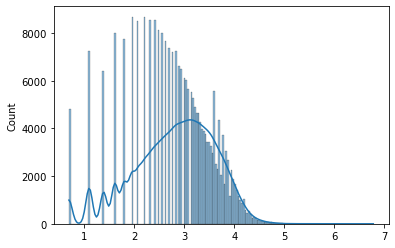

In [61]:
# log를 씌워 visitors의 분포를 정규화
# 이후 예측한 결과에 np.expm1()를 적용해 주어야 함 
y_train = np.log1p(y_train.values)

sns.histplot(y_train, kde=True)

### XGBRegressor

In [ ]:
from xgboost import XGBRegressor # XGBoost Regressor 모델

model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
model.fit(x_train, y_train)

In [ ]:
pred = model.predict(x_test)
print(len(pred))

# train_target에 log1p를 씌워서 정규화를 해주었기 때문에 expm1로 값을 복구해줍니다
pred = np.expm1(pred)
pred = np.clip(pred, a_min=1, a_max=None)
# pred = pred.astype(int)

In [ ]:
submission['visitors'] = pred
submission.to_csv('sampleSubmission.csv', index=False)